In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from plotActivity import plotActivity

In [2]:
path_to_outdir = './data/mSigAct/'

### Calculate prop from prop1 for custom prop in mSigAct


In [3]:
data_num_mutations = pd.DataFrame()
for exp in glob.glob(path_to_outdir + 'output/raw_output/all_relatable_sbs_prop1/*/*.exposure.csv'):
    df_exp = pd.read_csv(exp)
    df_exp['Type'] = df_exp.columns[1]
    df_exp = df_exp.rename(columns={df_exp.columns[0]:"SBS", df_exp.columns[1]:'NumMut'})
    data_num_mutations = pd.concat([data_num_mutations, df_exp], axis=0)

data_num_mutations.head()

,SBS,NumMut,Type
0,SBS30,279,diff_Lepidosauria__Ts...Tv
1,SBS19,136,diff_Lepidosauria__Ts...Tv
2,SBS23,132,diff_Lepidosauria__Ts...Tv
3,SBS12,112,diff_Lepidosauria__Ts...Tv
4,SBS26,104,diff_Lepidosauria__Ts...Tv


In [9]:
sum_sbs = data_num_mutations.groupby('SBS').agg({'NumMut': 'sum'}).reset_index()
sum_sbs['prop'] = sum_sbs['NumMut'] / sum_sbs['NumMut'].sum()
sum_sbs = sum_sbs.sort_values(by='prop', ascending=False)
sum_sbs.head(6) ### They are used in our 3d test with custom prop from 1

,SBS,NumMut,prop
3,SBS12,7964,0.319994
16,SBS30,7278,0.292430
12,SBS23,4922,0.197766
14,SBS26,1318,0.052957
9,SBS2,843,0.033872
22,SBS42,494,0.019849


### After running mSigAct with custom prop from 1 we can continue running this notebook

Make table for all test from mSigAct

In [10]:
for test_prop in ['custom_prop', 'all_relatable_sbs_prop1', 'custom_from1']:
    
    data_collect = pd.DataFrame() # tmp

    for exp in glob.glob(path_to_outdir + f'output/raw_output/{test_prop}/*/*.exposure.csv'):

        df_exp = pd.read_csv(exp)
        df_exp['Samples'] = df_exp.columns[1]
        df_exp = df_exp.rename(columns={df_exp.columns[0]:"SBS", df_exp.columns[1]:'NumMut'})
        df_exp = df_exp.pivot(index='Samples', columns='SBS', values='NumMut').reset_index()
        data_collect = pd.concat([data_collect, df_exp], axis=0)
        data_collect = data_collect.fillna(0)
    
    data_collect.to_csv(path_to_outdir + f'output/{test_prop}_Activities.txt', index=False, sep='\t')
    

collect distances of recontructed spectra after assignment

In [13]:
# collect distances of recontructed spectra after assignment
data_distances  = []
for distances_file in glob.glob(path_to_outdir + 'output/raw_output/*/*/*.distances.csv'):
    dist_df = pd.read_csv(distances_file, index_col=0).assign(
        params=distances_file.split('/')[-3],
        sample=distances_file.split('/')[-2],
    )
    data_distances.append(dist_df)
distances = pd.concat(data_distances)
distances.set_index(['params', 'sample']).to_csv('./data/mSigAct/output/Distances_mSigAct.csv')
distances
distances.to_csv(path_to_outdir + 'output/Distances_mSigAct.csv')

In [15]:
distances[distances.method == 'cosine']

,method,proposed.assignment,QP.assignment,params,sample
5,cosine,0.884236,0.887877,custom_prop,diff_Lepidosauria__Ts...Tv
5,cosine,0.922207,0.931646,custom_prop,high_Amphibia__Ts...Tv
5,cosine,0.846786,0.874286,custom_prop,diff_Aves__Ts...Tv
5,cosine,0.863813,0.884427,custom_prop,diff_Lepidosauria__Ts.only
5,cosine,0.928276,0.930945,custom_prop,diff_Mammalia__Ts...Tv
...,...,...,...,...,...
5,cosine,0.888044,0.922454,custom_from1,high_Amphibia__Ts.only
5,cosine,0.917290,0.921226,custom_from1,low_Mammalia__Ts.only
5,cosine,0.931808,0.937323,custom_from1,low_Actinopteri__Ts.only
5,cosine,0.911313,0.928601,custom_from1,diff_Actinopteri__Ts.only


/home/diliushchenko/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/diliushchenko/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/diliushchenko/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/diliushchenko/.local/lib/python3.10/site-packages/seaborn/_oldc

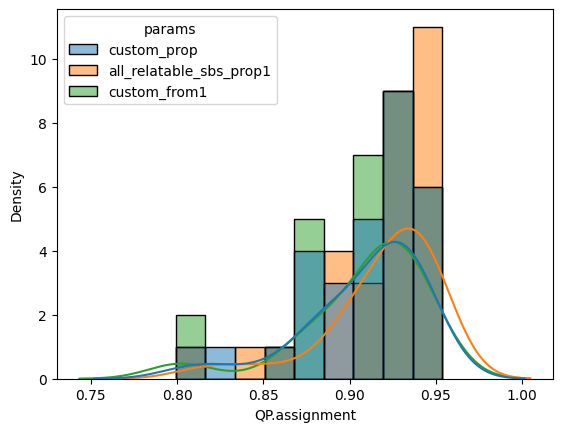

In [16]:
# prop1 == prop05 (prop05 covered by prop1)
sns.kdeplot(data=distances[(distances.method == 'cosine')].reset_index(), x='QP.assignment', hue='params');
sns.histplot(data=distances[(distances.method == 'cosine')].reset_index(), x='QP.assignment', hue='params');

In [26]:
#collect activities after assignment
data_activities = []

try_d_full_path = os.path.join(path_to_outdir, 'output/raw_output')
if os.path.isdir(try_d_full_path):
    d = []
    for activity_file in glob.glob(try_d_full_path + '/*/*/*.exposure.csv'):
        act_df = pd.read_csv(activity_file, index_col=0)
        d.append(act_df)
    try_act_df = pd.concat(d, axis=1).assign(params=try_d)
    data_activities.append(try_act_df)

activities = pd.concat(data_activities, axis=0)
activities.index.name = 'signature'
activities = activities.reset_index().set_index(['params', 'signature'])
activities.to_csv('./data/mSigAct/output/activities_total.csv')
activities.head()

diff_Lepidosauria__Ts...Tv  high_Amphibia__Ts...Tv  \
params signature                                                       
output SBS30                           266.0                   661.0   
       SBS23                           246.0                     NaN   
       SBS26                           221.0                     NaN   
       SBS5                            171.0                    72.0   
       SBS12                             NaN                   382.0   

                  diff_Aves__Ts...Tv  diff_Lepidosauria__Ts.only  \
params signature                                                   
output SBS30                   272.0                       227.0   
       SBS23                     NaN                       353.0   
       SBS26                     NaN                       230.0   
       SBS5                      NaN                         NaN   
       SBS12                   616.0                         NaN   

                  diff_Mammalia__Ts...Tv  low_Actinopteri__Ts...Tv  \
params signature                                                     
output SBS30                       235.0                      94.0   
       SBS23                       146.0                       NaN   
       SBS26                         NaN                       NaN   
       SBS5                        110.0                     198.0   
       SBS12                       399.0                     309.0   

                  high_Mammalia__Ts...Tv  low_Lepidosauria__Ts...Tv  \
params signature                                                      
output SBS30                       639.0                      103.0   
       SBS23                         NaN                        NaN   
       SBS26                         NaN                        NaN   
       SBS5                          NaN                      191.0   
       SBS12                       620.0                      183.0   

                  low_Amphibia__Ts.only  high_Mammalia__Ts.only  ...  \
params signature                                                 ...   
output SBS30                      278.0                   361.0  ...   
       SBS23                        NaN                   354.0  ...   
       SBS26                        NaN                     NaN  ...   
       SBS5                         NaN                     NaN  ...   
       SBS12                      229.0                   498.0  ...   

                  low_Mammalia__Ts...Tv  high_Lepidosauria__Ts.only  \
params signature                                                      
output SBS30                      182.0                       325.0   
       SBS23                        NaN                       456.0   
       SBS26                        NaN                         NaN   
       SBS5                         NaN                         NaN   
       SBS12                      218.0                       397.0   

                  diff_Actinopteri__Ts...Tv  high_Aves__Ts...Tv  \
params signature                                                  
output SBS30                          435.0               339.0   
       SBS23                            NaN               269.0   
       SBS26                            NaN                 NaN   
       SBS5                             NaN                 NaN   
       SBS12                           46.0               784.0   

                  diff_Aves__Ts.only  high_Amphibia__Ts.only  \
params signature                                               
output SBS30                   188.0                   354.0   
       SBS23                   254.0                   309.0   
       SBS26                     NaN                     NaN   
       SBS5                      NaN                     NaN   
       SBS12                   544.0                   330.0   

                  low_Mammalia__Ts.only  low_Actinopteri__Ts.only  \
params signature                                        

In [27]:
custom_colors = [
        '#acf2d0', 
        '#63d69e', 
        '#f8b6b3', 
        '#d9f7b0', 
        '#fae1a5', 
        '#fad682', 
        'tab:pink', 
        'tab:orange', 
        'tab:olive', 
        'tab:purple', 
        '#7852d9',
    ]

### Plot mSigAct with custom function
TODO: custom colors

In [30]:
msig_act_list = glob.glob('./data/mSigAct/output/*Activities.txt')
for msig_file in msig_act_list:
    activity_name = msig_file.split('/')[-1].split('Activities')[0]
    plotActivity(msig_file, output_file=path_to_outdir + f'output/figures/{activity_name}mSigAct.pdf')

['#acf2d0', '#63d69e', '#f8b6b3', '#f17fb2', '#c4abc4', '#f2aeae', '#d9f7b0', '#faf1dc', '#fcebc2', '#fae4af', '#fae1a5', '#fcde97', '#fad682', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:brown', 'tab:red', 'tab:green', 'tab:cyan', 'deeppink', 'orangered', 'blueviolet', 'chocolate', 'darkgreen', 'dodgerblue', 'mediumvioletred', 'salmon']
['#f8b6b3', '#fae1a5', '#fcde97', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive']
['#63d69e', '#fcde97', '#fad682', 'tab:pink', 'tab:orange', 'tab:purple', 'tab:olive']


In [31]:
d = activities.melt(ignore_index=False, var_name='sample', value_name='activity').reset_index()
d

,params,signature,sample,activity
0,output,SBS30,diff_Lepidosauria__Ts...Tv,266.0
1,output,SBS23,diff_Lepidosauria__Ts...Tv,246.0
2,output,SBS26,diff_Lepidosauria__Ts...Tv,221.0
3,output,SBS5,diff_Lepidosauria__Ts...Tv,171.0
4,output,SBS12,diff_Lepidosauria__Ts...Tv,NaN
...,...,...,...,...
2605,output,SBS15,diff_Amphibia__Ts.only,NaN
2606,output,SBS94,diff_Amphibia__Ts.only,NaN
2607,output,SBS13,diff_Amphibia__Ts.only,NaN
2608,output,SBS20,diff_Amphibia__Ts.only,NaN


<Axes: xlabel='signature', ylabel='activity'>

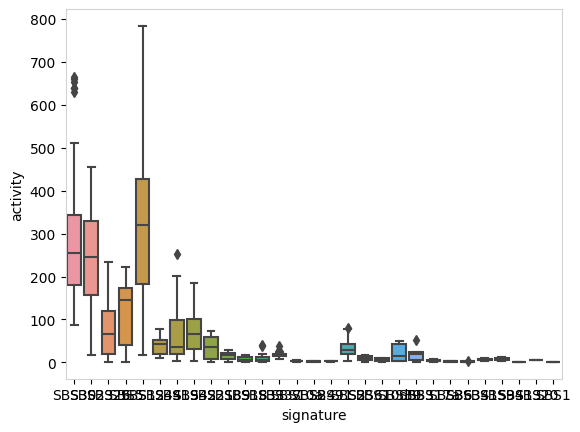

In [32]:
sns.boxplot(data=d, x='signature', y='activity')

<Axes: xlabel='sample', ylabel='activity'>

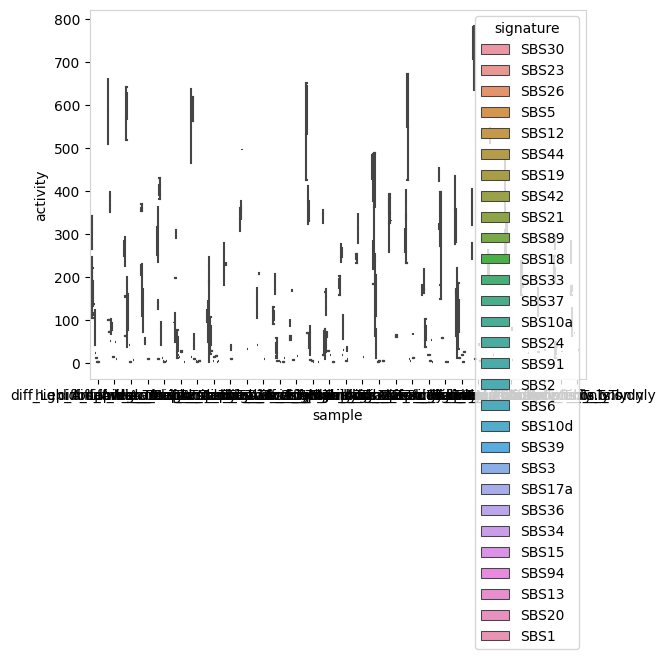

In [33]:
sns.boxplot(data=d, x='sample', y='activity', hue='signature')